In [1]:
from ase import Atom
from ase.build import bulk
from ase.db import connect
# from icet.tools import enumerate_structures
from tqdm import tqdm
from pymatgen.io.ase import AseAtomsAdaptor

In [2]:
from ase.lattice.cubic import FaceCenteredCubic, BodyCenteredCubic
from ase.visualize import view
atoms = BodyCenteredCubic('W')
view(atoms.repeat((2,2,2)), viewer = 'x3d')

In [ ]:
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.lattice.cubic import FaceCenteredCubic, BodyCenteredCubic
from ase.filters import FrechetCellFilter
from tqdm import tqdm

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

ev_to_gpa = 160.2176621
mlp_elastic_moduli = {}

for element in tqdm(['Nb']):
    atoms = BodyCenteredCubic(element).repeat(2)
    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        norm_strains=(-0.06, -0.03, 0.03, 0.06),
        shear_strains=(-0.06, -0.03, 0.03, 0.06),
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
        relax_initial=True,
        relax_strained=True,
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa / bulk_gpa

    # print(results['elastic_tensor'])
    
    # Store in dictionary
    mlp_elastic_moduli[element] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio,
    }
    print(f"{element}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}")

  0%|          | 0/1 [00:00<?, ?it/s]

10
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


100%|██████████| 1/1 [00:47<00:00, 47.64s/it]

Nb: Shear = 31.36 GPa, Bulk = 186.34 GPa, Pugh Ratio = 0.17


In [21]:
import numpy as np
np.round(np.abs(results['elastic_tensor'].voigt*ev_to_gpa))

array([[266., 147., 147.,   0.,   0.,   0.],
       [147., 266., 147.,   0.,   0.,   0.],
       [147., 147., 266.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  20.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  20.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  20.]])

In [22]:
tensor = results['elastic_tensor'].voigt*ev_to_gpa
(tensor[0][0]-tensor[1][2])/2

np.float64(59.42432284309375)

In [23]:
bulk_gpa/((tensor[0][0]-tensor[1][2])/2)

np.float64(3.135789312748716)

In [ ]:
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.lattice.cubic import FaceCenteredCubic, BodyCenteredCubic
from ase.filters import FrechetCellFilter
from tqdm import tqdm

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

ev_to_gpa = 160.2176621
mlp_elastic_moduli = {}

for element in tqdm(['Ta']):
    atoms = BodyCenteredCubic(element).repeat(2)
    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        norm_strains=(-0.1, -0.05, 0.05, 0.1),
        shear_strains=(-0.06, -0.03, 0.03, 0.06),
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
        relax_initial=True,
        relax_strained=True,
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa / bulk_gpa

    # print(results['elastic_tensor'])
    
    # Store in dictionary
    mlp_elastic_moduli[element] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio,
    }
    print(f"{element}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}")

  0%|          | 0/1 [00:00<?, ?it/s]

7
0
0
0
0
0
0
0
0


In [ ]:
tensor = results['elastic_tensor'].voigt*ev_to_gpa
(tensor[0][0]-tensor[1][2])/2

np.float64(43.94564421492032)

In [ ]:
bulk_gpa/((tensor[0][0]-tensor[1][2])/2)

np.float64(4.531522951324901)

In [12]:
import numpy as np

ev_to_gpa = 160.2176621
et = results['elastic_tensor']  # this is the pymatgen ElasticTensor-like object you printed

# Handle two possible shapes:
#  - if et is an ElasticTensor object that exposes to_voigt(), use that
#  - otherwise, assume it's a 3x3x3x3 numpy array
try:
    # pymatgen ElasticTensor has .voigt if available
    C_voigt = et.voigt   # 6x6 (if available)
except Exception:
    # assume numpy 3x3x3x3 -> convert to 6x6 voigt
    C4 = np.array(et)  # shape (3,3,3,3)
    voigt_map = {
        (0,0):0, (1,1):1, (2,2):2,
        (1,2):3, (0,2):4, (0,1):5,
        (2,1):3, (2,0):4, (1,0):5
    }
    C_voigt = np.zeros((6,6))
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    I = voigt_map[(i,j)]
                    J = voigt_map[(k,l)]
                    # Note: off-diagonal shear indexing should be handled carefully,
                    # but for symmetric elasticity tensors this mapping works:
                    C_voigt[I,J] = C4[i,j,k,l]

# Extract cubic independent constants (assuming cubic symmetry)
C11 = C_voigt[0,0]
C12 = C_voigt[0,1]
C44 = C_voigt[3,3]  # for Voigt index 3 = yz (same as xy/xz for cubic)

# convert to GPa
C11_GPa = C11 * ev_to_gpa
C12_GPa = C12 * ev_to_gpa
C44_GPa = C44 * ev_to_gpa

# Voigt / Reuss / VRH shear for cubic
Gv = (C11_GPa - C12_GPa + 3.0 * C44_GPa) / 5.0
Gr = 5.0 * (C11_GPa - C12_GPa) * C44_GPa / (4.0 * C44_GPa + 3.0 * (C11_GPa - C12_GPa))
Gvrh = 0.5 * (Gv + Gr)

print(f"C11 = {C11:.6f} eV/Å^3 = {C11_GPa:.2f} GPa")
print(f"C12 = {C12:.6f} eV/Å^3 = {C12_GPa:.2f} GPa")
print(f"C44 = {C44:.6f} eV/Å^3 = {C44_GPa:.2f} GPa")
print(f"G_V  = {Gv:.2f} GPa")
print(f"G_R  = {Gr:.2f} GPa")
print(f"G_VRH= {Gvrh:.2f} GPa")


C11 = 1.544399 eV/Å^3 = 247.44 GPa
C12 = 1.058742 eV/Å^3 = 169.63 GPa
C44 = 0.395325 eV/Å^3 = 63.34 GPa
G_V  = 53.57 GPa
G_R  = 50.62 GPa
G_VRH= 52.09 GPa


In [13]:
247.44 - 169.63 

77.81

In [19]:
import numpy as np

# Your 3x3x3x3 elastic tensor (replace with your actual tensor)
C = np.array(results['elastic_tensor'])
# Map 3x3x3x3 indices to Voigt 6x6
def ijkl_to_voigt(i,j,k,l):
    voigt = {0:0, 1:1, 2:2}
    shear = {(0,1):3, (1,0):3, (1,2):4, (2,1):4, (0,2):5, (2,0):5}
    def index(a,b):
        return voigt[a] if a==b else shear.get((a,b))
    return index(i,j), index(k,l)

C_voigt = np.zeros((6,6))
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                I, J = ijkl_to_voigt(i,j,k,l)
                C_voigt[I,J] = C[i,j,k,l]

# Voigt average (G_V) and Bulk modulus (B)
B = (C_voigt[0,0] + C_voigt[1,1] + C_voigt[2,2] + 2*(C_voigt[0,1] + C_voigt[0,2] + C_voigt[1,2]))/9
G_V = (C_voigt[0,0] + C_voigt[1,1] + C_voigt[2,2] - (C_voigt[0,1] + C_voigt[0,2] + C_voigt[1,2]) + 3*(C_voigt[3,3]+C_voigt[4,4]+C_voigt[5,5]))/15

# Reuss average (G_R)
S = np.linalg.inv(C_voigt)
G_R = 15 / (4*(S[0,0]+S[1,1]+S[2,2]) - 4*(S[0,1]+S[0,2]+S[1,2]) + 3*(S[3,3]+S[4,4]+S[5,5]))

# Hill average
G_H = (G_V + G_R)/2

print(f"Bulk modulus B = {B:.2f}")
print(f"Shear modulus Voigt G_V = {G_V:.2f}")
print(f"Shear modulus Reuss G_R = {G_R:.2f}")
print(f"Shear modulus Hill G_H = {G_H:.2f}")


Bulk modulus B = 1.18
Shear modulus Voigt G_V = 0.33
Shear modulus Reuss G_R = 0.31
Shear modulus Hill G_H = 0.32


In [3]:
primitive_structure = bulk('W')
primitive_structure

Atoms(symbols='W', pbc=True, cell=[[-1.58, 1.58, 1.58], [1.58, -1.58, 1.58], [1.58, 1.58, -1.58]])

In [7]:
from icet.tools import enumerate_structures
from ase.build import bulk
from tqdm import tqdm

primitive_structure = bulk("W")

conc_rest = {"Nb": (0.1, 0.1)}  # exactly 10% Nb
structures = []
for atoms in tqdm(enumerate_structures(primitive_structure,
                                      range(10, 11),
                                      ["W", "Ta", "Nb"],
                                      concentration_restrictions=conc_rest)):
    structures.append(atoms)

4764it [00:06, 743.28it/s] 


In [ ]:
import json
from pymatgen.io.ase import AseAtomsAdaptor

# convert all structures
pmg_structures = []
for atoms in structures:
    pmg_struct = AseAtomsAdaptor.get_structure(atoms)
    pmg_structures.append(pmg_struct.as_dict())

# save to JSON
with open("enumerated_structures.json", "w") as f:
    json.dump(pmg_structures, f, indent=2)

In [ ]:
import json
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor

# load from JSON
with open("enumerated_structures.json", "r") as f:
    loaded = json.load(f)

# convert JSON dicts → pymatgen Structures
pmg_structures = [Structure.from_dict(d) for d in loaded]

# convert pymatgen Structures → ASE Atoms
structures = [AseAtomsAdaptor.get_atoms(pmg) for pmg in pmg_structures]

In [3]:
from fairchem.core import pretrained_mlip, FAIRChemCalculator

# load predictor
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

W0925 17:24:25.389000 86579 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [ ]:
# from ase.optimize import LBFGS
# from ase.constraints import ExpCellFilter  # alias for FrechetCellFilter in new ASE
# from tqdm import tqdm

# relaxed_structures = []
# for atoms in tqdm(structures):
#     atoms.calc = calc
#     opt = LBFGS(ExpCellFilter(atoms))
#     opt.run(fmax=0.05, steps=200)
#     relaxed_structures.append(atoms.copy())

In [1]:
import json
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from ase.optimize import LBFGS
from ase.constraints import ExpCellFilter  # alias for FrechetCellFilter in new ASE
from tqdm import tqdm

# load JSON
with open("relaxed_structures.json", "r") as f:
    data = json.load(f)

# dicts → pymatgen structures
pmg_relaxed = [Structure.from_dict(d) for d in data]

# pymatgen structures → ASE atoms
relaxed_structures = [AseAtomsAdaptor.get_atoms(s) for s in pmg_relaxed]

In [2]:
from collections import defaultdict
from ase.build import bulk
from ase.optimize import LBFGS
from fairchem.core import pretrained_mlip, FAIRChemCalculator

# load predictor
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

# reference energies of pure elements
reference_energies = {}
for el in ["W", "Ta", "Nb"]:
    pure = bulk(el, cubic=True)
    pure.calc = calc
    opt = LBFGS(ExpCellFilter(pure))
    opt.run(fmax=0.05, steps=200)
    reference_energies[el] = pure.get_potential_energy() / len(pure)

W0925 17:25:32.410000 86612 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


       Step     Time          Energy          fmax
LBFGS:    0 17:25:42      -25.894567        1.337021


/var/folders/1f/_0ghpkvx4c14xmf15m39z5fr0000gn/T/ipykernel_86612/1657024910.py:15: FutureWarning: Import ExpCellFilter from ase.filters
  opt = LBFGS(ExpCellFilter(pure))


LBFGS:    1 17:25:42      -25.871288        2.034008
LBFGS:    2 17:25:42      -25.908362        0.099138
LBFGS:    3 17:25:42      -25.908443        0.008154
       Step     Time          Energy          fmax
LBFGS:    0 17:25:42      -23.626457        0.310414
LBFGS:    1 17:25:42      -23.626760        0.261352
LBFGS:    2 17:25:42      -23.627562        0.002838
       Step     Time          Energy          fmax
LBFGS:    0 17:25:42      -20.187595        0.678122
LBFGS:    1 17:25:43      -20.191772        0.381510
LBFGS:    2 17:25:43      -20.193791        0.006531


In [ ]:
import numpy as np

formation_energies = []

for atoms in tqdm(relaxed_structures):
    atoms.calc = calc
    E_tot = atoms.get_potential_energy()
    comp = atoms.get_chemical_symbols()
    n_atoms = len(comp)

    # sum reference energies
    E_ref = sum(comp.count(el) * reference_energies[el] for el in set(comp))
    
    E_form = (E_tot - E_ref) / n_atoms
    formation_energies.append((atoms, E_form))

  0%|          | 0/4764 [00:00<?, ?it/s]


In [9]:
sum(comp.count(el) * reference_energies[el] for el in set(comp))

-126.68488931121877

In [8]:
atoms.get_potential_energy()

-126.84855383100562

In [10]:
(E_tot - E_ref) / n_atoms

-0.016366451978684894

In [ ]:
# import json
# from pymatgen.io.ase import AseAtomsAdaptor

# # Save each structure and its formation energy as a dict
# to_save = []
# for atoms, E_form in formation_energies:
#     struct_dict = AseAtomsAdaptor.get_structure(atoms).as_dict()
#     to_save.append({
#         "structure": struct_dict,
#         "formation_energy": float(E_form)
#     })

# # Write to JSON
# with open("relaxed_structures_with_energies.json", "w") as f:
#     json.dump(to_save, f, indent=2)

In [12]:
import json
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor

# Load from JSON
with open("relaxed_structures_with_energies.json", "r") as f:
    data = json.load(f)

# Reconstruct formation_energies as a list of (ase.Atoms, formation_energy)
formation_energies = []
for entry in data:
    pmg_struct = Structure.from_dict(entry["structure"])
    atoms = AseAtomsAdaptor.get_atoms(pmg_struct)
    formation_energies.append((atoms, entry["formation_energy"]))

In [13]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

lowest_by_comp = defaultdict(lambda: (None, np.inf))

for atoms, E_form in tqdm(formation_energies):
    formula = atoms.get_chemical_formula()
    if E_form < lowest_by_comp[formula][1]:
        lowest_by_comp[formula] = (atoms, E_form)

# print results
for formula, (atoms, E_form) in lowest_by_comp.items():
    print(f"{formula}: lowest formation energy = {E_form:.4f} eV/atom")

100%|██████████| 4764/4764 [00:00<00:00, 101716.85it/s]

NbW9: lowest formation energy = -0.0282 eV/atom
NbTaW8: lowest formation energy = -0.0623 eV/atom
NbTa2W7: lowest formation energy = -0.0827 eV/atom
NbTa3W6: lowest formation energy = -0.0895 eV/atom
NbTa4W5: lowest formation energy = -0.0882 eV/atom
NbTa5W4: lowest formation energy = -0.0799 eV/atom
NbTa6W3: lowest formation energy = -0.0638 eV/atom
NbTa7W2: lowest formation energy = -0.0442 eV/atom
NbTa8W: lowest formation energy = -0.0237 eV/atom
NbTa9: lowest formation energy = -0.0008 eV/atom


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import re

def tungsten_fraction(formula):
    match = re.search(r'W(\d*)', formula)
    if match:
        w_count = int(match.group(1)) if match.group(1) else 1
    else:
        w_count = 0
    counts = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    total = sum(int(n) if n else 1 for el, n in counts)
    return w_count / total if total > 0 else 0

# Gather all formation energies and tungsten fractions
all_fractions = []
all_energies = []

for atoms, E_form in formation_energies:
    formula = atoms.get_chemical_formula()
    frac = tungsten_fraction(formula)
    all_fractions.append(frac)
    all_energies.append(E_form)

all_fractions = np.array(all_fractions)
all_energies = np.array(all_energies)

# Get lowest formation energy for each composition
lowest_fractions = []
lowest_energies = []
for formula, (atoms, E_form) in lowest_by_comp.items():
    frac = tungsten_fraction(formula)
    lowest_fractions.append(frac)
    lowest_energies.append(E_form)
lowest_fractions = np.array(lowest_fractions)
lowest_energies = np.array(lowest_energies)
sort_idx = np.argsort(lowest_fractions)
lowest_fractions = lowest_fractions[sort_idx]
lowest_energies = lowest_energies[sort_idx]

In [16]:
lowest_by_comp['NbTa5W4'][0]

MSONAtoms(symbols='NbTa2W2Ta3W2', pbc=True, cell=[[-3.2567412386607186, 3.2567541423281248, 0.0003823704468580649], [-1.640549102069178, -4.897118511007561, 1.64037699955545], [3.2564162201291835, 3.257193864690296, 6.514170586268375]])

In [18]:
from ase.visualize import view
view(lowest_by_comp['NbTa5W4'][0].repeat(2), viewer='x3d')  # or 'ngl', 'jmol', etc.

In [19]:
from ase.calculators.emt import EMT
from ase.eos import calculate_eos
atoms = lowest_by_comp['NbTa5W4'][0]
atoms.calc = EMT()
eos = calculate_eos(atoms)
v, e, B = eos.fit()

NotImplementedError: No EMT-potential for Nb

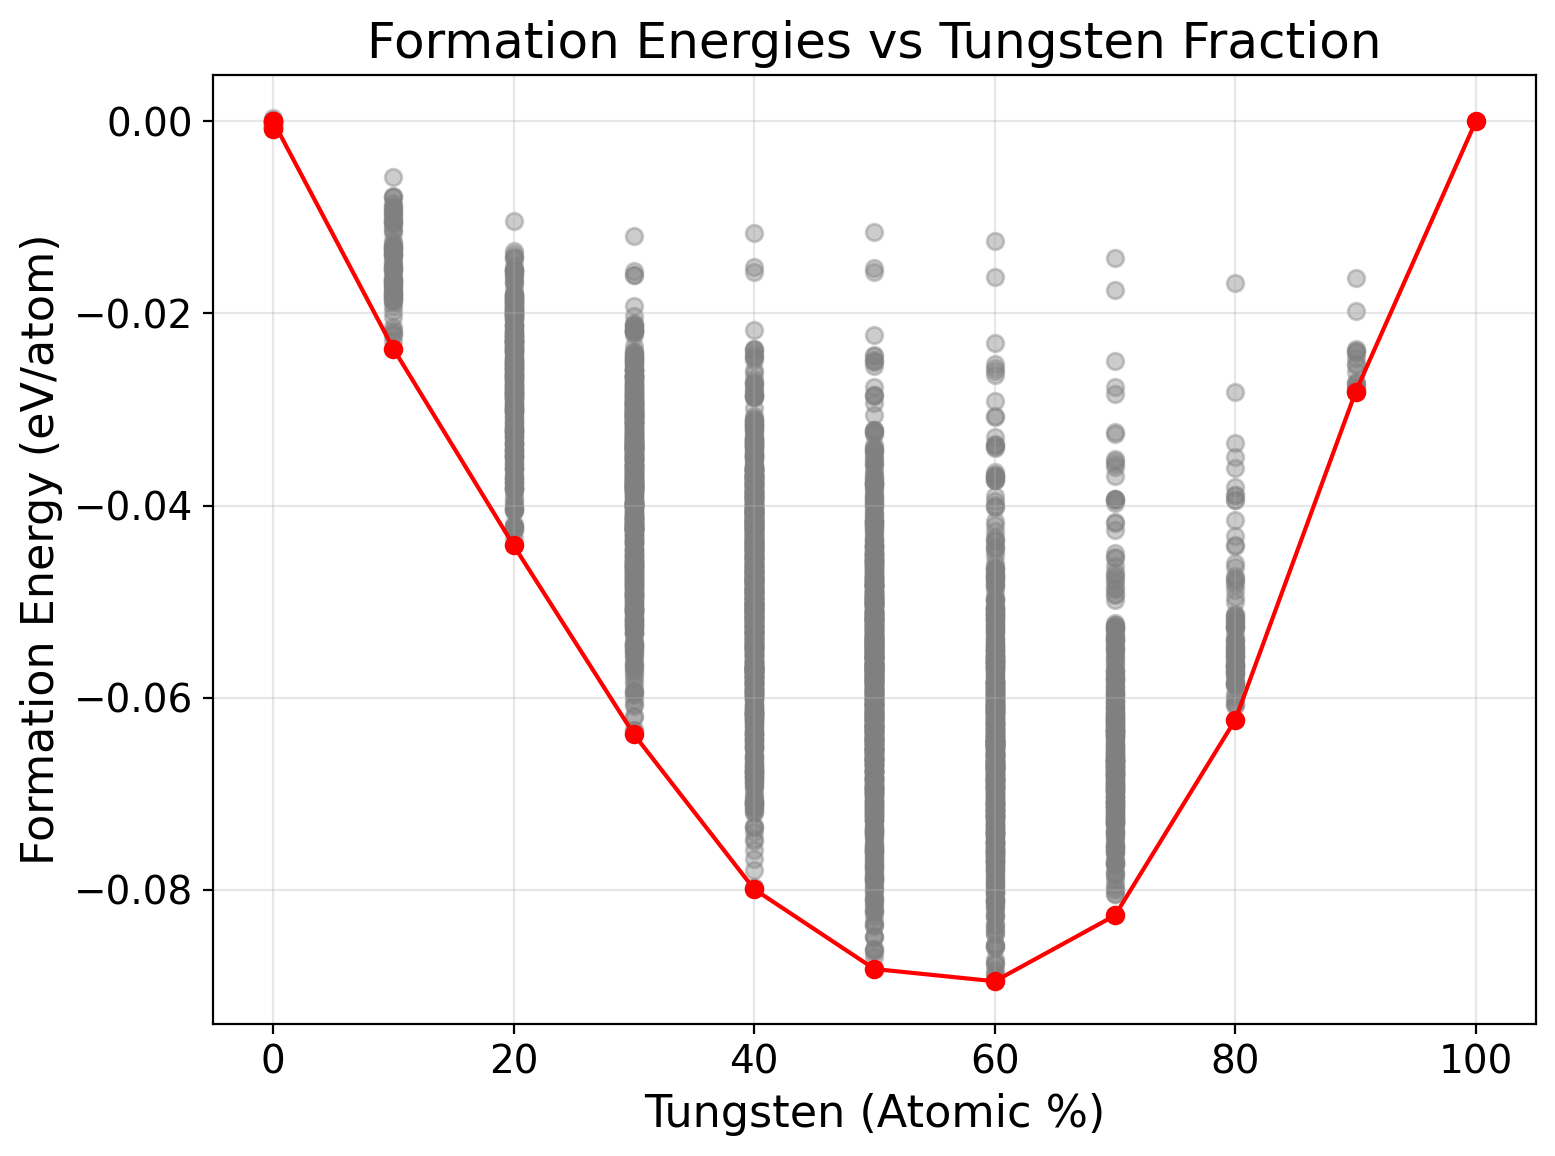

In [117]:
# Include pure elements in the lowest per composition curve
all_lowest_fractions = np.concatenate([lowest_fractions, [0.0, 0.0, 1.0]])  # Nb, Ta, W
all_lowest_energies = np.concatenate([lowest_energies, [0.0, 0.0, 0.0]])    # formation energy = 0

# Sort by tungsten fraction
sort_idx = np.argsort(all_lowest_fractions)
all_lowest_fractions = all_lowest_fractions[sort_idx]
all_lowest_energies = all_lowest_energies[sort_idx]

import matplotlib.pyplot as plt
import numpy as np

# # Set high-quality figure parameters
# plt.rcParams.update({
#     'figure.dpi': 200,       # higher resolution
#     'font.size': 14,         # base font size for labels and legend
#     'axes.labelsize': 16,    # x and y label size
#     'axes.titlesize': 18,    # title size
#     'xtick.labelsize': 14,   # x tick labels
#     'ytick.labelsize': 14,   # y tick labels
#     'legend.fontsize': 14
# })

plt.figure(figsize=(8,6))
plt.scatter(all_fractions*100, all_energies, alpha=0.4, color='gray', label='All formation energies')
plt.plot(all_lowest_fractions*100, all_lowest_energies, 'o-', color='red', label='Lowest per composition')
plt.xlabel('Tungsten (Atomic %)', fontsize=16)
plt.ylabel('Formation Energy (eV/atom)', fontsize=16)
plt.title('Formation Energies vs Tungsten Fraction', fontsize=18)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.filters import FrechetCellFilter
from tqdm import tqdm

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

ev_to_gpa = 160.2176621
mlp_elastic_moduli = {}

for name, (atoms, E_form) in tqdm(lowest_by_comp.items()):
    # Calculate elasticity
    results = calculate_elasticity(
        atoms,
        calculator=calc,
        cell_filter_cls=FrechetCellFilter,
        fix_symmetry=False,
        relax_initial=True,
        relax_strained=True,
    )
    
    # Convert to GPa
    shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
    bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
    pugh_ratio = shear_gpa / bulk_gpa
    
    # Store in dictionary
    mlp_elastic_moduli[name] = {
        'shear_modulus_vrh': shear_gpa,
        'bulk_modulus_vrh': bulk_gpa,
        'pugh_ratio': pugh_ratio,
        'formation_energy': E_form
    }
    print(f"{name}: Shear = {shear_gpa:.2f} GPa, Bulk = {bulk_gpa:.2f} GPa, Pugh Ratio = {pugh_ratio:.2f}, Formation Energy = {E_form:.4f} eV/atom")

 10%|█         | 1/10 [00:17<02:33, 17.06s/it]

NbW9: Shear = 147.29 GPa, Bulk = 295.72 GPa, Pugh Ratio = 0.50, Formation Energy = -0.0282 eV/atom


 20%|██        | 2/10 [00:46<03:13, 24.13s/it]

NbTaW8: Shear = 135.63 GPa, Bulk = 287.30 GPa, Pugh Ratio = 0.47, Formation Energy = -0.0623 eV/atom


 30%|███       | 3/10 [01:11<02:52, 24.60s/it]

NbTa2W7: Shear = 119.11 GPa, Bulk = 272.65 GPa, Pugh Ratio = 0.44, Formation Energy = -0.0827 eV/atom


 40%|████      | 4/10 [01:28<02:09, 21.54s/it]

NbTa3W6: Shear = 103.18 GPa, Bulk = 255.36 GPa, Pugh Ratio = 0.40, Formation Energy = -0.0895 eV/atom


 50%|█████     | 5/10 [02:06<02:17, 27.45s/it]

NbTa4W5: Shear = 89.49 GPa, Bulk = 241.51 GPa, Pugh Ratio = 0.37, Formation Energy = -0.0882 eV/atom


 60%|██████    | 6/10 [02:31<01:46, 26.75s/it]

NbTa5W4: Shear = 79.39 GPa, Bulk = 230.40 GPa, Pugh Ratio = 0.34, Formation Energy = -0.0799 eV/atom


 70%|███████   | 7/10 [02:54<01:16, 25.52s/it]

NbTa6W3: Shear = 70.49 GPa, Bulk = 218.50 GPa, Pugh Ratio = 0.32, Formation Energy = -0.0638 eV/atom


 80%|████████  | 8/10 [03:18<00:50, 25.21s/it]

NbTa7W2: Shear = 62.32 GPa, Bulk = 209.03 GPa, Pugh Ratio = 0.30, Formation Energy = -0.0442 eV/atom


 90%|█████████ | 9/10 [03:41<00:24, 24.29s/it]

NbTa8W: Shear = 54.94 GPa, Bulk = 199.35 GPa, Pugh Ratio = 0.28, Formation Energy = -0.0237 eV/atom


100%|██████████| 10/10 [04:04<00:00, 24.49s/it]

NbTa9: Shear = 47.65 GPa, Bulk = 187.56 GPa, Pugh Ratio = 0.25, Formation Energy = -0.0008 eV/atom


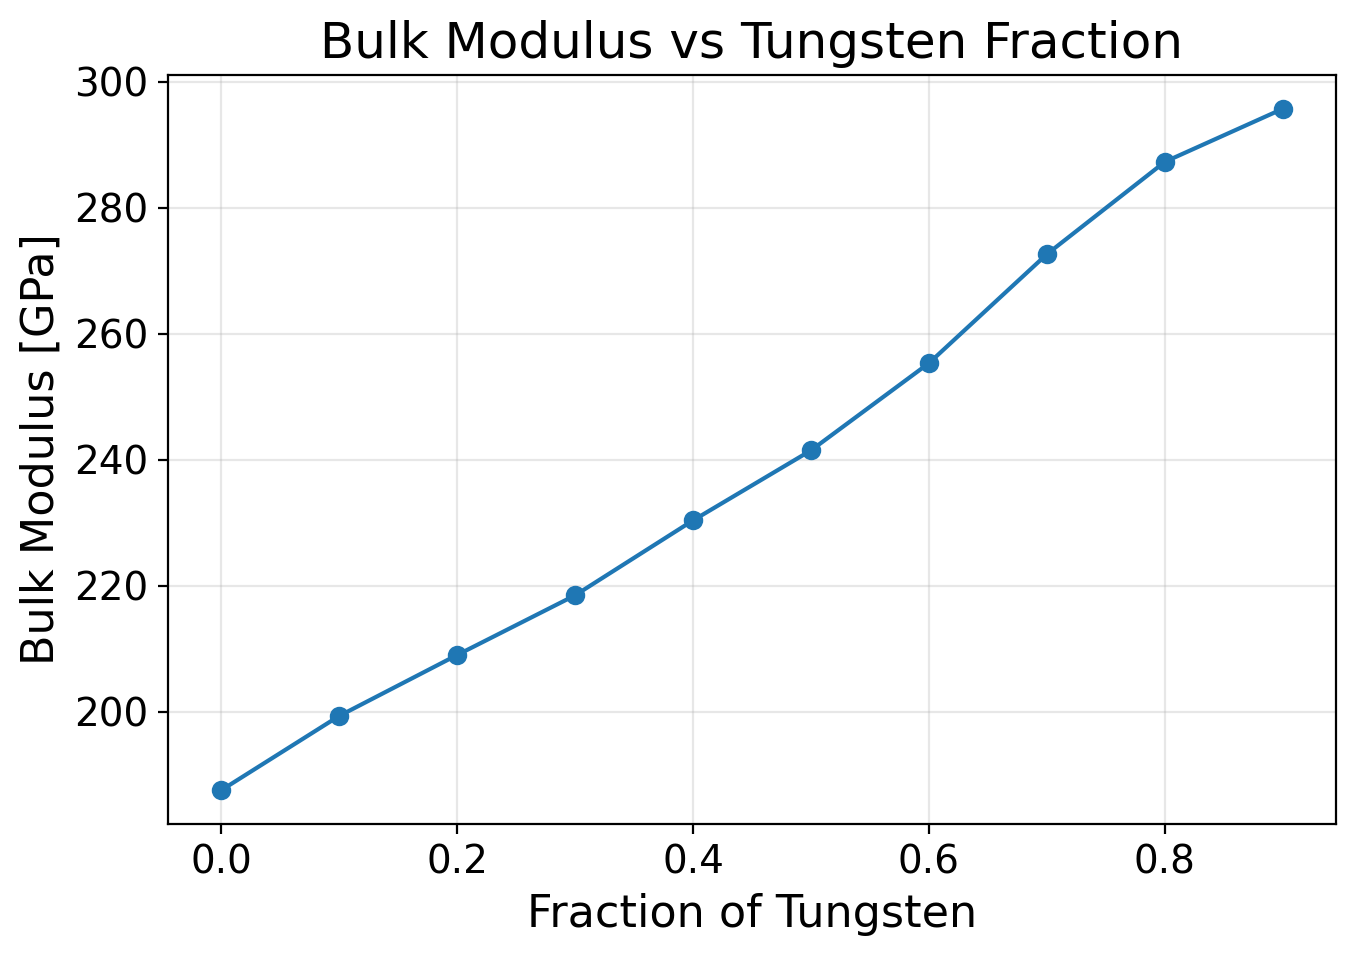

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import re

def tungsten_fraction(formula):
    # Extract number after 'W' (or 1 if just 'W')
    match = re.search(r'W(\d*)', formula)
    if match:
        w_count = int(match.group(1)) if match.group(1) else 1
    else:
        w_count = 0
    # Extract all element counts
    counts = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    total = sum(int(n) if n else 1 for el, n in counts)
    return w_count / total if total > 0 else 0

# Prepare data for plotting
fractions = np.array([tungsten_fraction(k) for k in mlp_elastic_moduli.keys()])
bulk_modulus = np.array([v['bulk_modulus_vrh'] for v in mlp_elastic_moduli.values()])
shear_modulus = np.array([v['shear_modulus_vrh'] for v in mlp_elastic_moduli.values()])
pugh_ratio = np.array([v['pugh_ratio'] for v in mlp_elastic_moduli.values()])

# Sort by fraction
sort_idx = np.argsort(fractions)
fractions = fractions[sort_idx]
bulk_modulus = bulk_modulus[sort_idx]
shear_modulus = shear_modulus[sort_idx]
pugh_ratio = pugh_ratio[sort_idx]

# Plot Bulk modulus
plt.figure(figsize=(7,5))
plt.plot(fractions, bulk_modulus, marker='o', label='Bulk modulus (VRH)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('Bulk Modulus [GPa]')
plt.title('Bulk Modulus vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

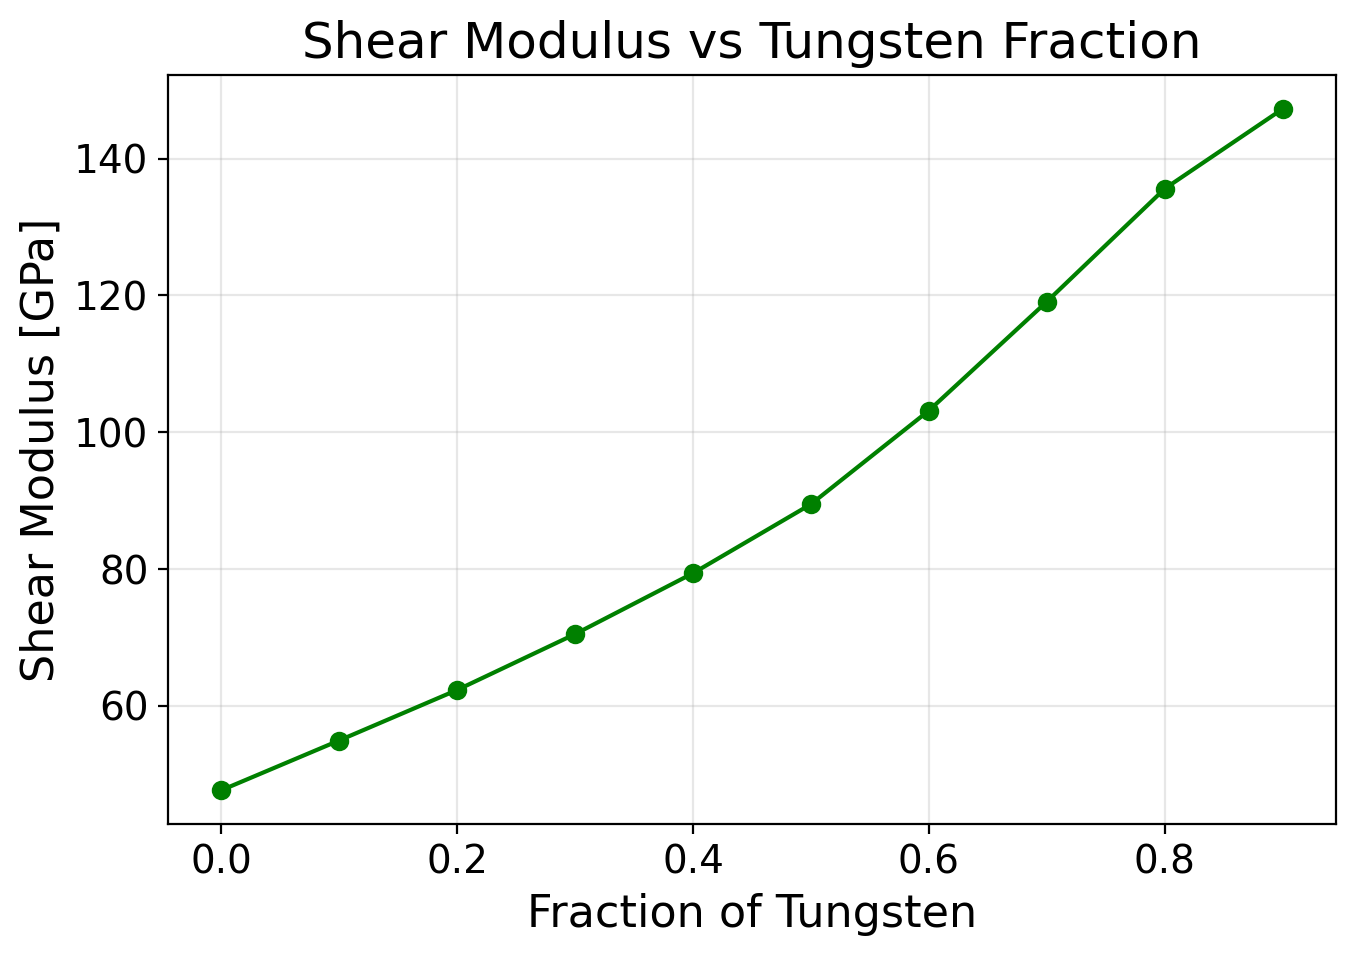

In [106]:
# Plot Shear modulus vs Tungsten fraction
plt.figure(figsize=(7,5))
plt.plot(fractions, shear_modulus, marker='o', color='green', label='Shear modulus (VRH)')
plt.xlabel('Fraction of Tungsten')
plt.ylabel('Shear Modulus [GPa]')
plt.title('Shear Modulus vs Tungsten Fraction')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

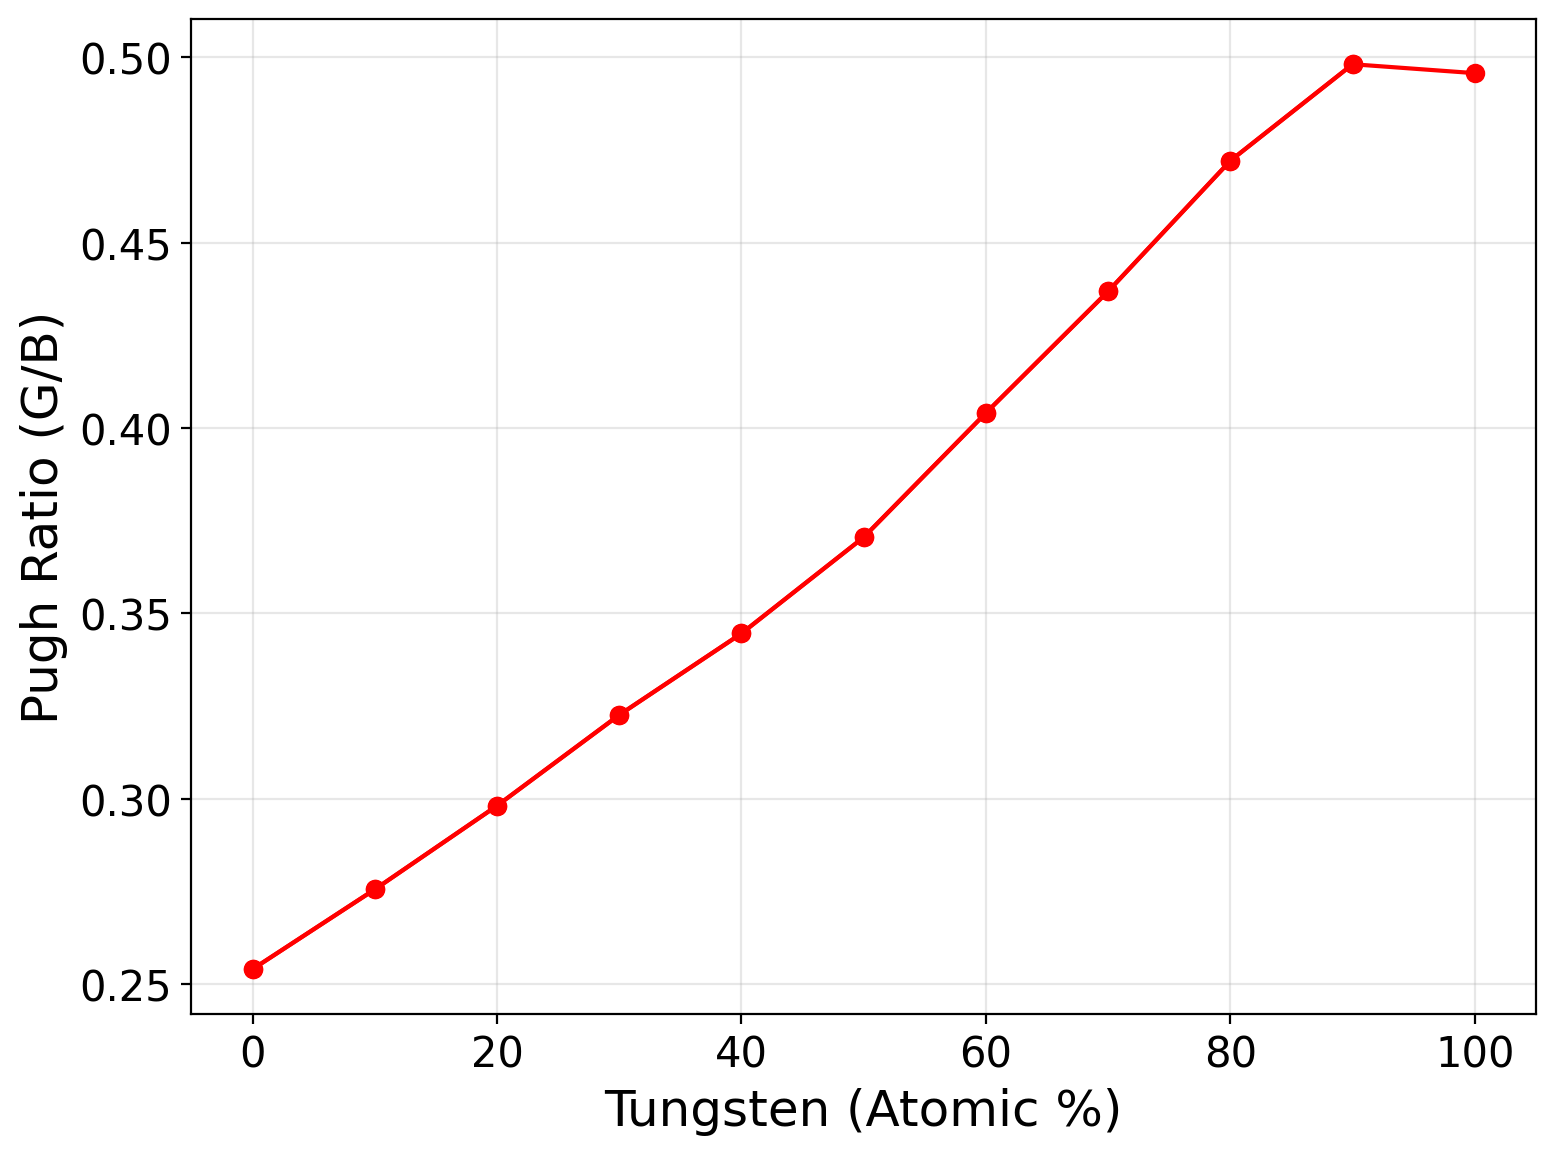

In [110]:
# Plot Pugh ratio vs Tungsten fraction
plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.array(fractions)*100, pugh_ratio, marker='o', color='red', label='Pugh ratio')
# Add pure W as a red point and connect with a line
plt.plot(
    np.append(fractions*100, 100.0),
    np.append(pugh_ratio, pure_w_pugh),
    'o-', color='red'
)
plt.xlabel('Tungsten (Atomic %)', fontsize=18)
plt.ylabel('Pugh Ratio (G/B)', fontsize=18)
# plt.title('Pugh Ratio vs Tungsten Fraction', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Calculate properties with the 10 random formation energy structures

In [91]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import random

# Group all structures by composition
by_comp = defaultdict(list)
for atoms, E_form in tqdm(formation_energies):
    formula = atoms.get_chemical_formula()
    by_comp[formula].append((atoms, E_form))

# For each composition, randomly sample 10 structures
random_10_by_comp = defaultdict(list)
random.seed(42)  # Set seed for reproducibility
for formula, struct_list in by_comp.items():
    # Randomly sample up to 10 structures
    sample_size = min(10, len(struct_list))
    random_10_by_comp[formula] = random.sample(struct_list, sample_size)

100%|██████████| 4764/4764 [00:00<00:00, 98827.64it/s]


In [92]:
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.filters import FrechetCellFilter
from tqdm import tqdm

predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")

ev_to_gpa = 160.2176621

# Store results as: {formula: [ {'bulk': ..., 'shear': ..., 'pugh': ..., 'E_form': ...}, ... ]}
moduli_by_comp = {}

for formula, struct_list in tqdm(random_10_by_comp.items()):
    moduli_by_comp[formula] = []
    for atoms, E_form in struct_list:
        results = calculate_elasticity(
            atoms,
            calculator=calc,
            cell_filter_cls=FrechetCellFilter,
            fix_symmetry=False,
            relax_initial=False,
            relax_strained=False,
        )
        shear_gpa = results['shear_modulus_vrh'] * ev_to_gpa
        bulk_gpa = results['bulk_modulus_vrh'] * ev_to_gpa
        pugh_ratio = shear_gpa / bulk_gpa
        moduli_by_comp[formula].append({
            'shear_modulus_vrh': shear_gpa,
            'bulk_modulus_vrh': bulk_gpa,
            'pugh_ratio': pugh_ratio,
            'formation_energy': E_form
        })

100%|██████████| 10/10 [23:53<00:00, 143.38s/it]


In [93]:
import matplotlib.pyplot as plt
import numpy as np
import re

def tungsten_fraction(formula):
    match = re.search(r'W(\d*)', formula)
    if match:
        w_count = int(match.group(1)) if match.group(1) else 1
    else:
        w_count = 0
    counts = re.findall(r'([A-Z][a-z]*)(\d*)', formula)
    total = sum(int(n) if n else 1 for el, n in counts)
    return w_count / total if total > 0 else 0

# Prepare data for plotting
fractions = []
bulk_means = []
bulk_stds = []
shear_means = []
shear_stds = []

for formula, moduli_list in moduli_by_comp.items():
    frac = tungsten_fraction(formula)
    bulk_vals = [d['bulk_modulus_vrh'] for d in moduli_list]
    shear_vals = [d['shear_modulus_vrh'] for d in moduli_list]
    fractions.append(frac)
    bulk_means.append(np.mean(bulk_vals))
    bulk_stds.append(np.std(bulk_vals))
    shear_means.append(np.mean(shear_vals))
    shear_stds.append(np.std(shear_vals))

# Sort by tungsten fraction
sort_idx = np.argsort(fractions)
fractions = np.array(fractions)[sort_idx]
bulk_means = np.array(bulk_means)[sort_idx]
bulk_stds = np.array(bulk_stds)[sort_idx]
shear_means = np.array(shear_means)[sort_idx]
shear_stds = np.array(shear_stds)[sort_idx]

In [94]:
from ase.build import bulk
from elastic_utils import calculate_elasticity
from fairchem.core import pretrained_mlip, FAIRChemCalculator
from ase.filters import FrechetCellFilter

# Calculate elastic properties for pure W using the same workflow
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1", device="cpu")
calc = FAIRChemCalculator(predictor, task_name="omat")
ev_to_gpa = 160.2176621

pure_w_atoms = bulk("W", cubic=True)
results_w = calculate_elasticity(
    pure_w_atoms,
    calculator=calc,
    cell_filter_cls=FrechetCellFilter,
    fix_symmetry=False,
    relax_initial=False,
    relax_strained=False,
)
pure_w_bulk = results_w['bulk_modulus_vrh'] * ev_to_gpa
pure_w_shear = results_w['shear_modulus_vrh'] * ev_to_gpa
pure_w_pugh = pure_w_shear / pure_w_bulk

print(f"Pure W: Bulk = {pure_w_bulk:.2f} GPa, Shear = {pure_w_shear:.2f} GPa, Pugh Ratio = {pure_w_pugh:.2f}")

Pure W: Bulk = 341.37 GPa, Shear = 169.21 GPa, Pugh Ratio = 0.50


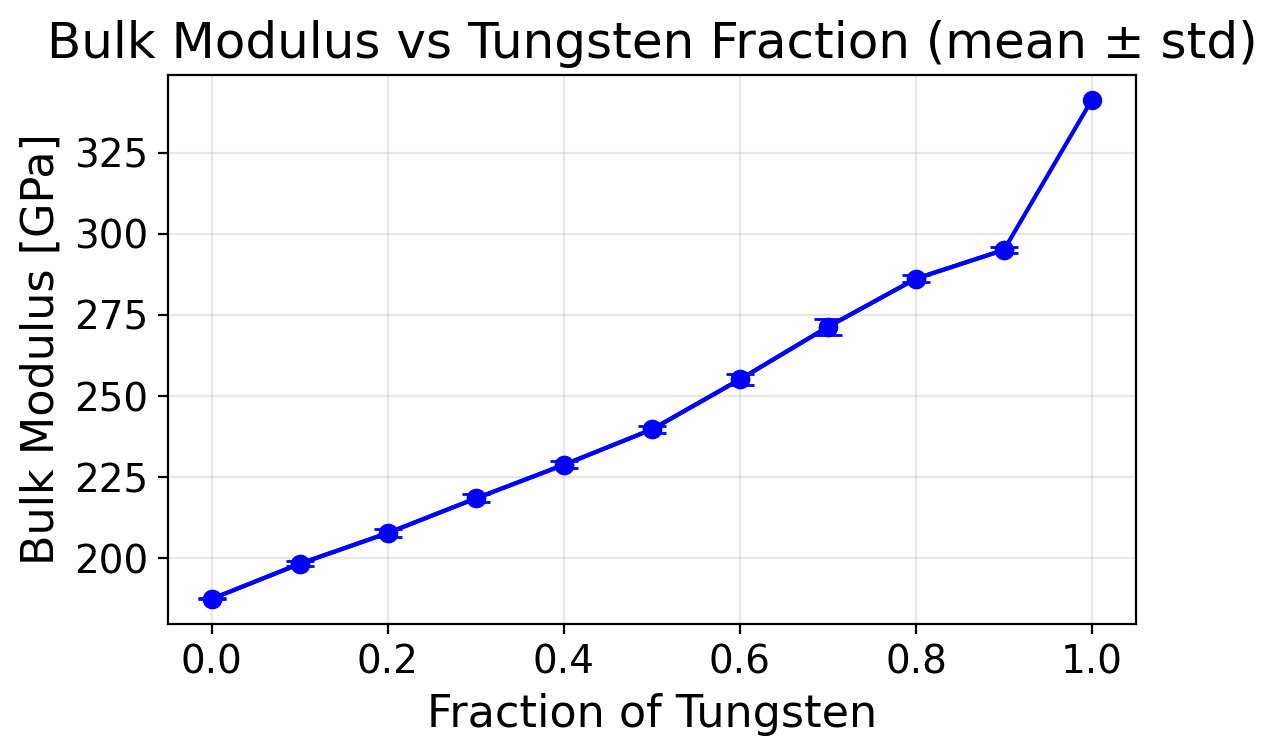

In [115]:
# Plot Bulk modulus with error bars and add pure W as a connected point in blue
plt.figure(figsize=(6,4))
plt.errorbar(
    fractions, bulk_means, yerr=bulk_stds, fmt='o-', capsize=5,
    color='blue', label='Bulk modulus (VRH)'
)
# Add pure W as a blue point and connect with a line
plt.plot(
    np.append(fractions, 1.0),
    np.append(bulk_means, pure_w_bulk),
    'o-', color='blue'
)
plt.xlabel('Fraction of Tungsten', fontsize=16)
plt.ylabel('Bulk Modulus [GPa]', fontsize=16)
plt.title('Bulk Modulus vs Tungsten Fraction (mean ± std)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

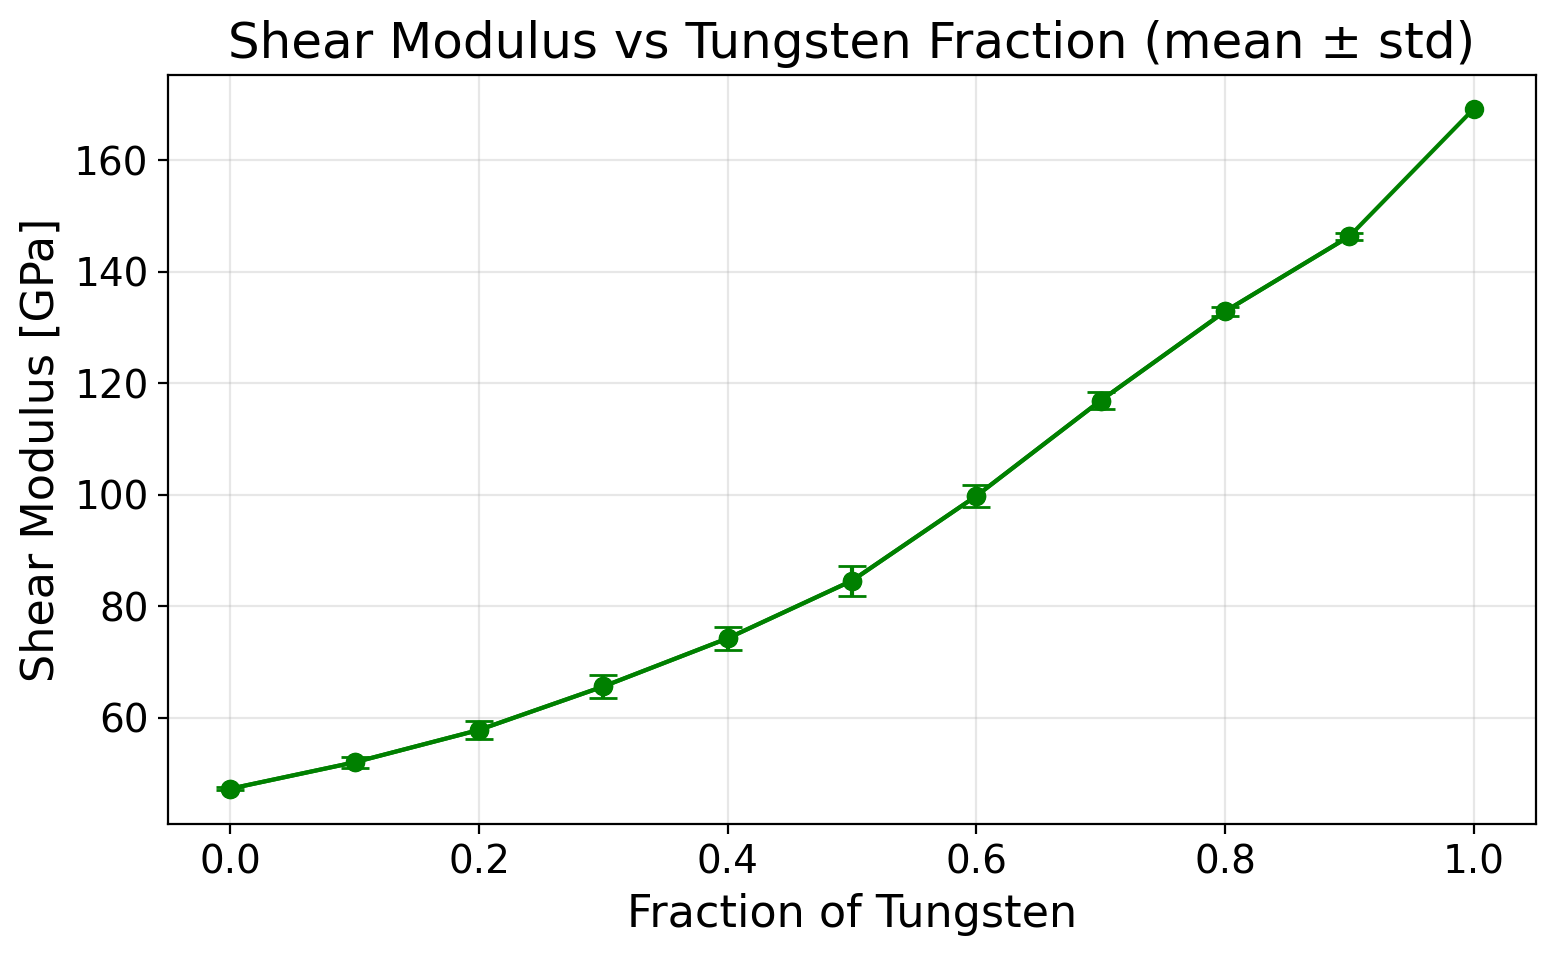

In [96]:
# Plot Shear modulus with error bars
plt.figure(figsize=(8,5))
plt.errorbar(fractions, shear_means, yerr=shear_stds, fmt='o-', capsize=5, color='green', label='Shear modulus (VRH)')
# Add pure W as a green point and connect with a line
plt.plot(
    np.append(fractions, 1.0),
    np.append(shear_means, pure_w_shear),
    'o-', color='green'
)
plt.xlabel('Fraction of Tungsten', fontsize=16)
plt.ylabel('Shear Modulus [GPa]', fontsize=16)
plt.title('Shear Modulus vs Tungsten Fraction (mean ± std)', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

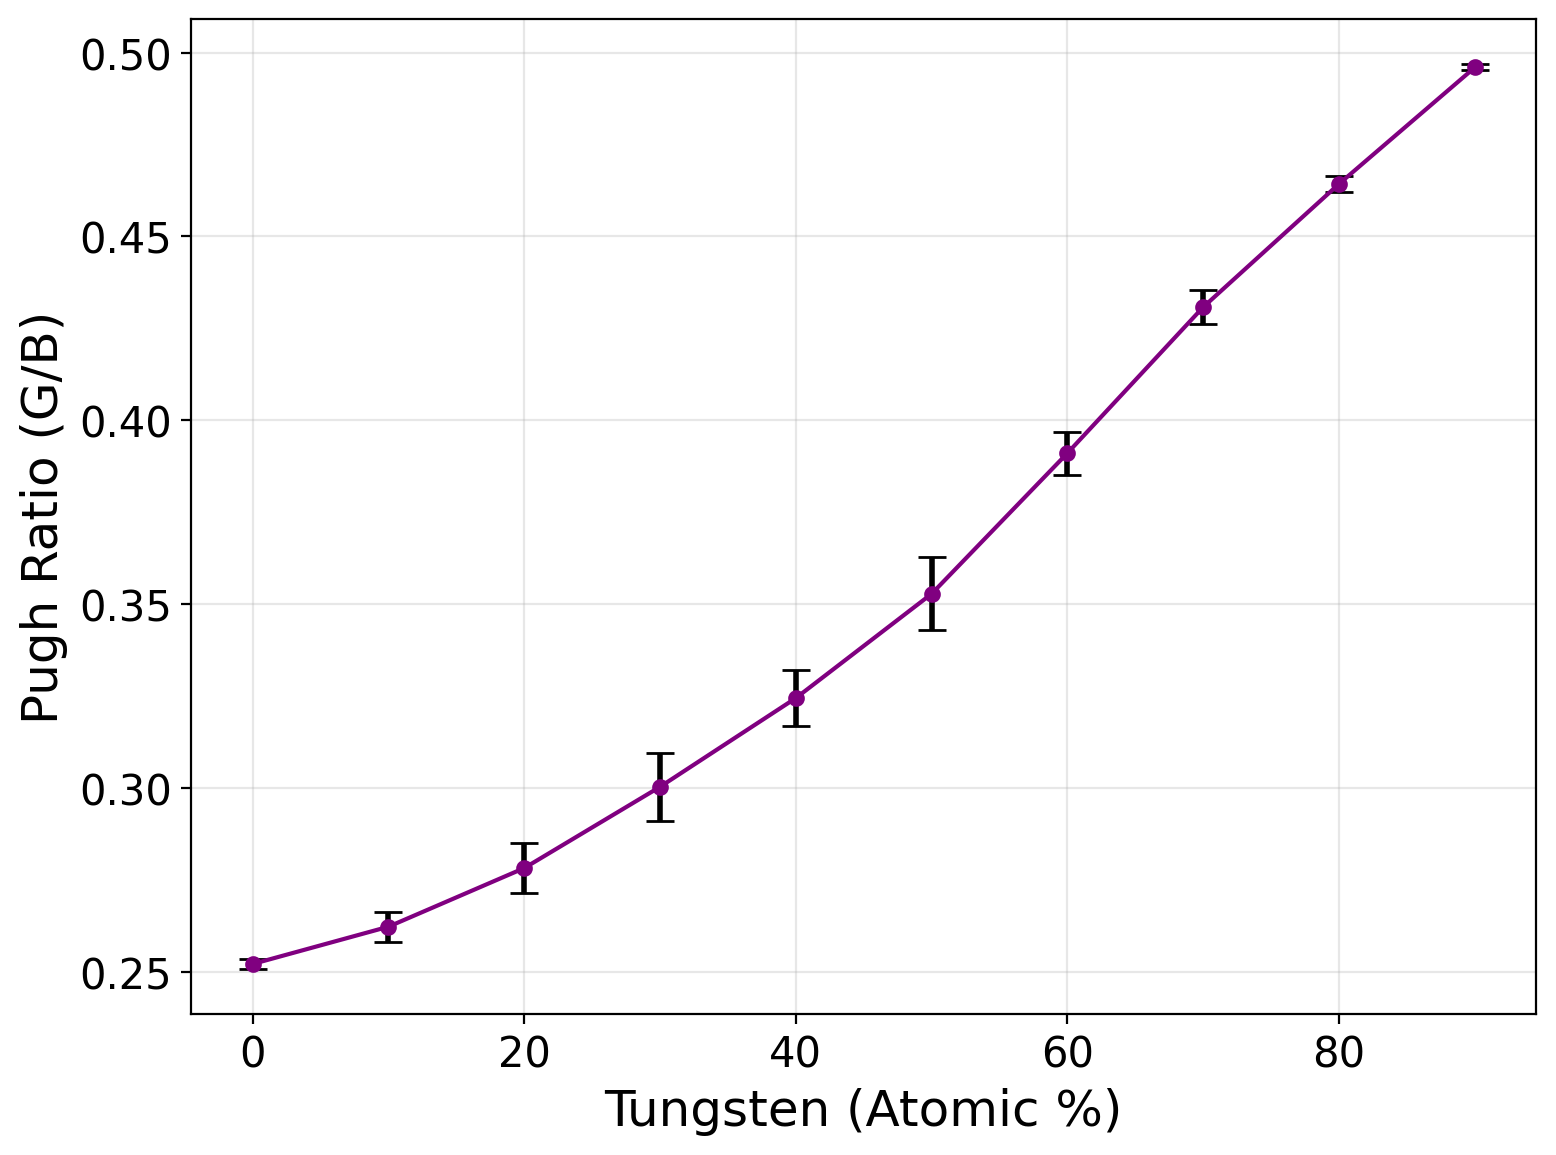

In [113]:
# Plot Pugh ratio with error bars and increased font sizes, smaller points for clarity
pugh_means = []
pugh_stds = []
frac_list = []

for formula, moduli_list in moduli_by_comp.items():
    frac = tungsten_fraction(formula)
    frac_list.append(frac)
    pugh_vals = [d['pugh_ratio'] for d in moduli_list]
    pugh_means.append(np.mean(pugh_vals))
    pugh_stds.append(np.std(pugh_vals))

# Convert to arrays and sort by tungsten fraction
frac_array = np.array(frac_list)
pugh_means = np.array(pugh_means)
pugh_stds = np.array(pugh_stds)
sort_idx = np.argsort(frac_array)
frac_array = frac_array[sort_idx]
pugh_means = pugh_means[sort_idx]
pugh_stds = pugh_stds[sort_idx]

plt.figure(figsize=(8,6))
plt.errorbar(
    frac_array*100, pugh_means, yerr=pugh_stds, fmt='o-', markersize=5, capsize=5,
    color='purple', ecolor='black', elinewidth=2, label='Pugh ratio (G/B)'
)
plt.xlabel('Tungsten (Atomic %)', fontsize=18)
plt.ylabel('Pugh Ratio (G/B)', fontsize=18)
# plt.title('Pugh Ratio vs Tungsten Fraction', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.legend()